# Multiple sclerosis lesion prediction

Authors:
  + Karma Tarap
  + Alexander Noll
  
## Abstract

# Introduction

The goal of this work is to be able to localize lesions in multiple sclerosis (MS) patients. These lesions can be found mainly in the **white matter (WM)** tissue of the brain. Magnetic resonance imaging (MRI) is used to diagnose and monitor MS. The problem in using MRI in this image segmentation problem is that manual annotation of lesions is expensive and time consuming (a single MRI image consists of $512 \times 512 \times 512$ pixels). Also, there is variation in manual annotations between different physicians. 

This fact makes the problem at hand important to solve automatically, but also shows the problem: supervised machine learning usually requires a big number of labelled examples. Furthermore, only a relatively small proportion of the brain volume (~1.5%) is affected by a lesion and thus, the problem of lesion segmentation is **highly imbalanced**. 

Our approach to improving on this imbalance uses **Generative Adverserial Networks (GANs)** [Goodfellow, 2014](https://arxiv.org/abs/1406.2661) to oversample the minority class. This is done by training a **deep convolutional GAN (DCGAN)** [Radford et al., 2015](https://arxiv.org/abs/1511.06434) on patches around a voxel of interest. The trained GAN can then be used to sample realistic patches of brain volume that look like a brain lesion. 

Using this technique, we can improve the classification accuracy by enhancing the original dataset with sampled new patches.

# Methods

# Data

We mainly use the [2008 MICCAI MS Lesion Segmentation Challenge](https://www.nitrc.org/projects/msseg/) dataset. Note that this dataset is rather large (41GB), so when replicating the results, please make sure that enough disk space is available. 

The dataset was downloaded from the website above and uploaded to an S3 bucket for easy access. The next code chunk downloads this dataset to the local drive. When the code is executed on an EC2 machine in N. Virgina, the download should take around 5 minutes.

In [1]:
import urllib.request
import os.path
import zipfile
import os


files = ['https://s3.amazonaws.com/csci82projectdata/ms-2008/CHB_test1_Part1.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/CHB_test1_Part2.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/CHB_test1_Part3.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/CHB_train_Part1.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/CHB_train_Part2.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/UNC_test1_Part1.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/UNC_test1_Part2.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/UNC_train_Part1.zip',
         'https://s3.amazonaws.com/csci82projectdata/ms-2008/UNC_train_Part2.zip']

def download_and_unzip(url):
    """
    Downloads and extracts file from S3 bucket. After extraction, the zip file is deleted.
    """
    folder = url[51:66]
    target_file = os.path.join('data', folder + '.zip')
    urllib.request.urlretrieve(url, target_file)    
    
    zip_ref = zipfile.ZipFile(target_file, 'r')
    zip_ref.extractall(os.path.join('data', folder))
    zip_ref.close()
    
    os.remove(target_file)
    
for file in files: 
    download_and_unzip(file)

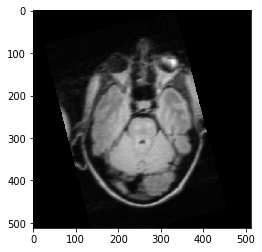

In [1]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

A = np.fromfile('./data/CHB_test1_Part1/CHB_test1_Case01/CHB_test1_Case01_FLAIR.raw', dtype='int16', sep="")
A = A.reshape([512, 512, 512])
plt.imshow(A[197, :, :], cmap='gray')

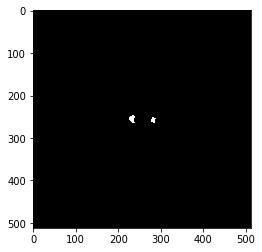

In [1]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

A = np.fromfile('./data/UNC_train_Part1/UNC_train_Case01/UNC_train_Case01_lesion.raw', dtype='int16', sep="")
A = A.reshape([512, 512, 512])
plt.imshow(A[197, :, :], cmap='gray')

## Generative Adverserial Network

In the following, we define the architecture of the generative adverserial network and train it. The implementation is done in `TensorFlow`. We split the set of MRI scans into a training and cross validation dataset. The same split will later be maintained when we do the image segmentation. Splitting here may or may not be necessary, but in any case, it can avoid a possible information leakage from the training set. When submitting the final results, of course, both the GAN and the segmentation models are retrained on the entire dataset.

### Data Generator

We start with the task of writing a custom training generator. In order to achieve that, we first store the locations of all MRI files that we will be using in a list. We split this list into a training and validation set. Afterwards, a helper function is defined which allows to easily read in an MRI image by just specifying the path. This function is subsequently used to read in all the MRI files. Note that this will probably lead to problems on standard laptops or desktop PCs. This script was executed on Amazon Web Services (AWS) using `p2.xlarge` instance which has sufficient memory. 

In [2]:
import numpy as np

files = ['CHB_train_Part1/CHB_train_Case0' + str(i) + '/CHB_train_Case0' + str(i) for i in range(1, 6)]
files += ['CHB_train_Part2/CHB_train_Case0' + str(i) + '/CHB_train_Case0' + str(i) for i in range(6, 10)]
files += ['CHB_train_Part2/CHB_train_Case10/CHB_train_Case10']
files += ['UNC_train_Part1/UNC_train_Case0' + str(i) + '/UNC_train_Case0' + str(i) for i in range(1, 6)]
files += ['UNC_train_Part2/UNC_train_Case0' + str(i) + '/UNC_train_Case0' + str(i) for i in range(6, 10)]
files += ['UNC_train_Part2/UNC_train_Case10/UNC_train_Case10']
files = ['data/' + file for file in files]
train_files = np.random.choice(files, size=15, replace=False)
test_files = [file for file in files if file not in train_files]

In [3]:
def read_directory(image):
    """
    Reads the channels (FLAIR, T1, T2) of an MRI and the segmented lesions from a directory containing the MRI scan.
    
    :param image_dir: path containing the MRI scans
    """
    x = [np.fromfile(image + ending, dtype='float16', sep='') for ending in ['_FLAIR.raw', '_T1.raw', '_T2.raw']]
    x = [np.reshape(xx, (512, 512, 512)) for xx in x]
    x = np.stack(x)
    
    target_file = image + '_lesion.raw'
    target = np.reshape(np.fromfile(target_file, dtype='int16', sep=""), (512, 512, 512))
    return x, target

all_files = [read_directory(file) for file in train_files]

After reading in all MRI files, a training generator is defined. This training generator can be used to generate patches around a lesion voxel to be fed into the GAN. The training generator is parametrized by the `batch_size` which indicates the number of patches and by `patch_size` which parametrizes how many neighboring voxels will be incorporated into the sampled patch. 

The generator works as follows:

1. It samples `batch_size` training images (as defined above) with replacement.
2. For each sampled training image, it samples one lesion voxel and computes a region of the appropriate patch size around it. Here the implicit assumption is that the `patch_size` is small enough so that the patch around the voxel of interest is still in the interior of the brain. This assumption usually holds for small enough patch size (say 10). These sampled patches are returned.

In [43]:
def train_generator(train_images, batch_size, patch_size):
    """
    Generates patches of size `patch_size` around lesion voxels. It procedes by first randomly sampling one of
    the 20 MRI scans. Then it takes a patch of size `patch_size x patch_size x patch_size` centered around 
    this voxel.
    
    :param batch_size: number of patches sampled
    :param patch_size: size of sampled patch
    """
    while True:

        # Loop over batches
        samples = []
        for i in range(batch_size):
            # Sample an image
            sampled_image = np.random.randint(len(train_images))
            x, y = train_images[sampled_image]

            # Sample a lesion voxel
            lesion_voxels = np.where(y == 1)
            sampled_voxel_index = np.random.randint(len(lesion_voxels[0]))
            sampled_voxel = list(lesion_voxels[i][sampled_voxel_index] for i in range(3))

            # Calculate sampled patch
            sampled_patch = x[:,
                              int(sampled_voxel[0] - patch_size / 2 + 1) : int(sampled_voxel[0] + patch_size / 2), 
                              int(sampled_voxel[1] - patch_size / 2 + 1) : int(sampled_voxel[1] + patch_size / 2),
                              int(sampled_voxel[2] - patch_size / 2 + 1) : int(sampled_voxel[2] + patch_size / 2)]

            samples.append(sampled_patch)

        results = np.stack(samples)
        yield results

In [54]:
batch_size = 10
patch_size = 14
foo = train_generator(all_files, batch_size=batch_size, patch_size=patch_size)

In [46]:
next(foo).shape

(10, 3, 13, 13, 13)

### GAN Architecture

We next procede to describe the architecture of the Generative Adverserial Network. 

#### Generator network

It works as follows:

1. We sample from an uncorrelated normal distribution of dimenison 100.
2. The so created random vector is passed through a fully connected layer of size $3\times 3\times 3\times 3 = 81$ and reshaped to (3, 3, 3, 3).
3. A [batch normalization](https://arxiv.org/abs/1502.03167) layer is applied.
4. Afterwards, we pass the output through a [leaky relu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks).
5. This vector is upsampled with a three dimensional transposed convolution to size $(3, 6, 6, 6)$ using 'same' padding.
6. This output goes through a three-dimensional [transposed convolution](https://arxiv.org/abs/1603.07285).
7. Batch Normalization.
8. Leaky relu.
9. Another transposed convolution is applied with 'valid' padding.
10. Hyperbolic tangent.


In [7]:
def generator(z, reuse=False, alpha=0.2, training=True):
    """
    Defines the generator for the GAN.
    
    :param z: input tensor
    :param reuse: boolean used later to decide whether or not to reuse the weights
    :param alpha: alpha parameter of leaky relu
    :param training: parameter for batch normalization
    """
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 100*3*3*3)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (batch_size, 100, 3, 3, 3))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 100x3x3x3 now
        
        x2 = tf.layers.conv3d_transpose(x1, filters=50, kernel_size=2, strides=2, padding='same', data_format='channels_first')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 50x6x6x6 now
        
        x3 = tf.layers.conv3d_transpose(x2, 3, 3, strides=2, padding='valid', data_format='channels_first')
        # 3x13x13x13 now
        out = tf.tanh(x3)
        
        return out

#### Discriminator

In the next code chunke, the discriminator network is defined:

In [17]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Defines the tensors for the discriminator network.
    
    :param images: input images
    :param reuse: Boolean indicating if the weights should be reused
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 3x13x13x13x13
        z = tf.transpose(images, perm=[0, 2, 3, 4, 1])
        x1 = tf.layers.conv3d(z, filters=64, kernel_size=5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # Shape is 7x7x7x64
        
        x2 = tf.layers.conv3d(relu1, filters=128, kernel_size=5, strides=2, padding='same')
        relu2 = tf.maximum(alpha * x2, x2)
        # Shape is 4x4x4x128
        
        x3 = tf.layers.conv3d(relu2, filters=256, kernel_size=5, strides=2, padding='same')
        relu3 = tf.maximum(alpha * x3, x3)
        # Shape is 2x2x2x256
        
        flat = tf.reshape(relu3, (-1, 2*2*2*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits

import tensorflow as tf        
tf.reset_default_graph()
z = tf.placeholder(tf.float32, shape=(None, 3, 13, 13, 13))
discriminator(z, reuse=False)

(<tf.Tensor 'discriminator/Sigmoid:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'discriminator/dense/BiasAdd:0' shape=(?, 1) dtype=float32>)

In [18]:
tf.reset_default_graph()
z_size = 100
inputs_z = tf.placeholder(tf.float32, (batch_size, z_size), name='input_z')
foo = generator(inputs_z)

#### Loss

The optimization goal of a GAN consists of two components:

1. The **discriminator** is supposed to be able to distinguish between the generated samples and the true samples. It thus needs a loss that is small when the discriminator can, in fact, distinguish between generated and true samples. Consequentially, a **cross entropy** loss is used to optimize the discrimintaor.
2. The **generator** needs a loss that is low when the discriminator is **not able** to distinguish between artificial and true samples. This is accomplished by setting reversing the labels in the generator loss below.

In [206]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=0.9*tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

#### Optimizers

The optimizers are defined. We obtain two separate optimizers: one for optimizing the discriminator and one for optimizing the generator.

In [207]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

#### Training

Finally, we define the method used for training the GAN.

0
1
2
3
4
5
6
7
8
9


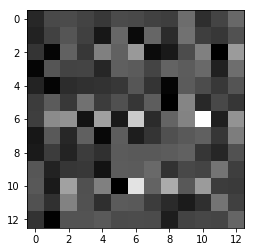

10
11
12
13
14
15
16
17
18
19


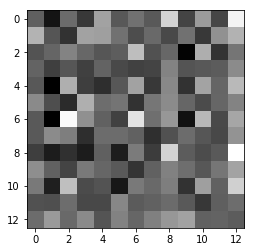

20
21
22
23
24
25
26
27
28
29


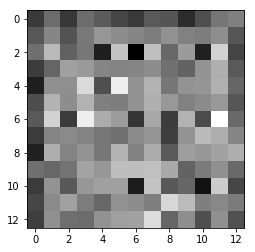

30
31
32
33
34
35
36
37
38
39


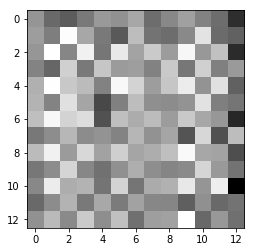

40
41
42
43
44
45
46
47
48
49


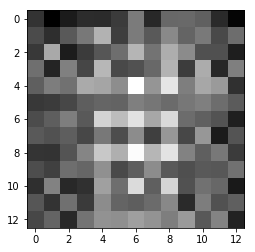

50
51
52
53
54
55
56
57
58
59


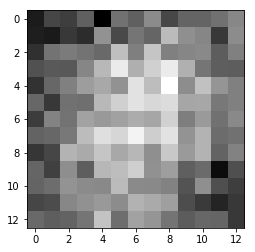

60
61
62
63
64
65
66
67
68
69


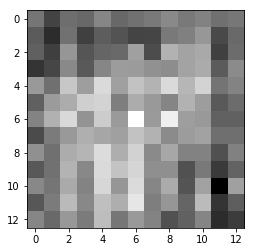

70
71
72
73
74
75
76
77
78
79


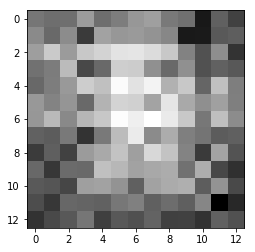

80
81
82
83
84
85
86
87
88
89


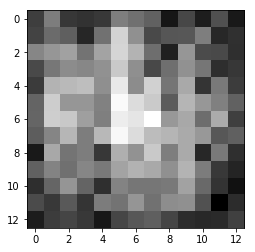

90
91
92
93
94
95
96
97
98
99
Epoch 1/100... Discriminator Loss: 1.2177... Generator Loss: 0.5990


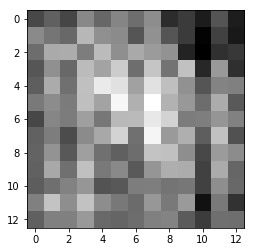

100
101
102
103
104
105
106
107
108
109


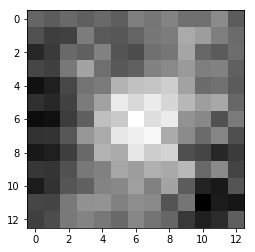

110
111
112
113
114
115
116
117
118
119


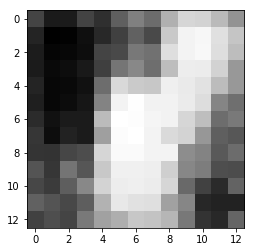

120
121
122
123
124
125
126
127
128
129


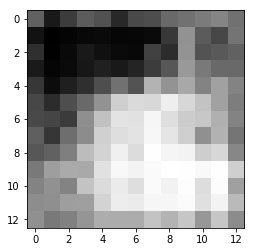

130
131
132
133
134
135
136
137
138
139


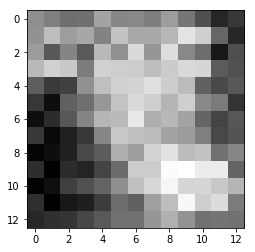

140
141
142
143
144
145
146
147
148
149


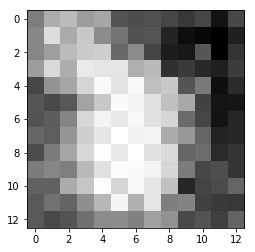

150
151
152
153
154
155
156
157
158
159


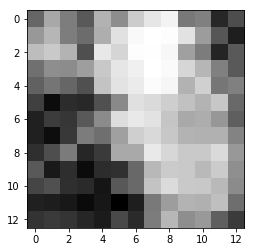

160
161
162
163
164
165
166
167
168
169


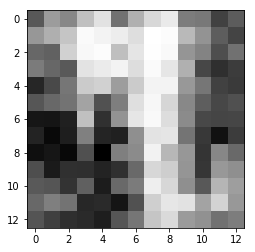

170
171
172
173
174
175
176
177
178
179


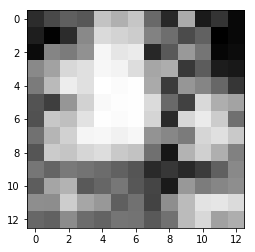

180
181
182
183
184
185
186
187
188
189


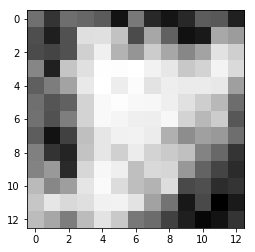

190
191
192
193
194
195
196
197
198
199
Epoch 2/100... Discriminator Loss: 1.2523... Generator Loss: 0.5969


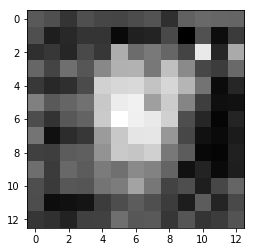

200
201
202
203
204
205
206
207
208
209


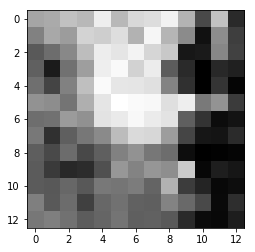

210
211
212
213
214
215
216
217
218
219


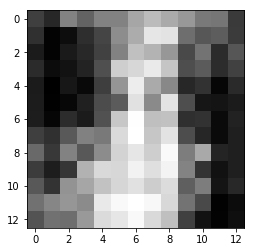

220
221
222
223
224
225
226
227
228
229


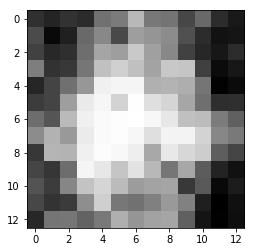

230
231
232
233
234
235
236
237
238
239


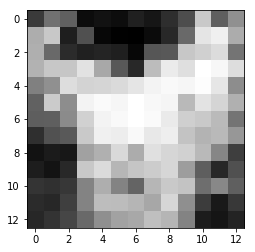

240
241
242
243
244
245
246
247
248
249


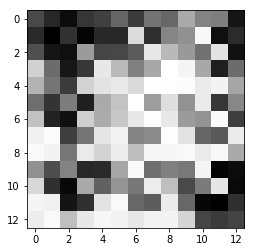

250
251
252
253
254
255
256
257
258
259


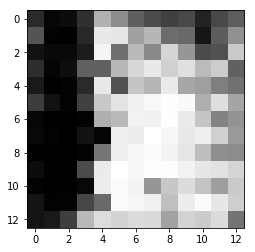

260
261
262
263
264
265
266
267
268
269


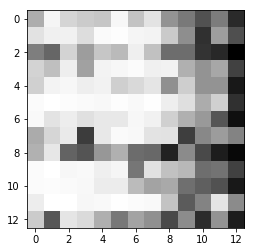

270
271
272
273
274
275
276
277
278
279


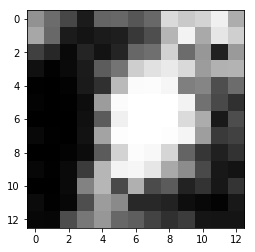

280
281
282
283
284
285
286
287
288
289


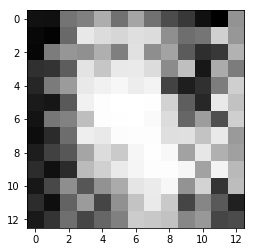

290
291
292
293
294
295
296
297
298
299
Epoch 3/100... Discriminator Loss: 1.3046... Generator Loss: 0.5701


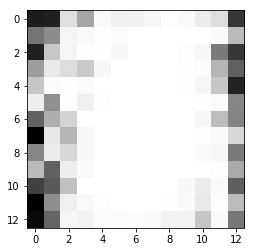

300
301
302
303
304
305
306
307
308
309


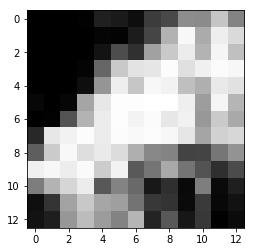

310
311
312
313
314
315
316
317
318
319


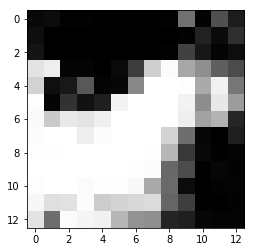

320
321
322
323
324
325
326
327
328
329


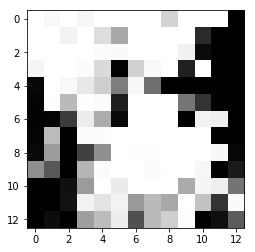

330
331


In [ ]:
def model_inputs(image_size, z_dim):
    """
    Create the model inputs and learning rate placeholder.
    :param image_width: tuple of image dimensions
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Real image inputs
    input_real = tf.placeholder(tf.float32, (None, *image_size), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return input_real, input_z, learning_rate

def train(epoch_count, batch_size, patch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param patch_size: patch size around center voxel
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    """
     
    input_real, input_z, learning_rate_tensor = model_inputs(data_shape, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[0])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for i in range(steps_per_epoch):
                batch_images = next(get_batches)
                batch_images = normalize(batch_images)
                batch_z = np.random.normal(0, 1, size=(batch_size, z_dim))
                #print("Discriminator loss: {}".format(d_loss.eval({input_z: batch_z, input_real: batch_images})))
                
                while d_loss.eval({input_z: batch_z, input_real: batch_images}) > 0.6:
                    #print("Discriminator loss: {}".format(d_loss.eval({input_z: batch_z, input_real: batch_images})))
                    _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                    batch_images = next(get_batches)
                    batch_images = normalize(batch_images)
                    batch_z = np.random.normal(0, 1, size=(batch_size, z_dim))
                print(steps)
                #print("Generator loss: {}".format(g_loss.eval({input_z: batch_z})))
                while g_loss.eval({input_z: batch_z}) > 0.6:
                    #print("Generator loss: {}".format(g_loss.eval({input_z: batch_z})))
                    batch_z = np.random.normal(0, 1, size=(batch_size, z_dim))
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                    
                steps += 1
                # Sample random noise for G
                #batch_images = normalize(batch_images)
                #batch_images *= 2.0
                #batch_z = np.random.normal(0, 1, size=(batch_size, z_dim))
                #batch_z *= 2
                
                # Run optimizers
                #_ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                   # Save losses to view after training
                
                if steps % show_every == 0:    
                    show_generator_output(sess, input_z)

learning_rate = 0.00003
z_dim = 100
batch_size = 10
patch_size = 14
beta1 = 0.5
n_images = 10
print_every = 100
show_every = 10
data_shape = (3, 13, 13, 13)


epochs = 100
steps_per_epoch = 100
#gen = train_generator(train_files, batch_size, patch_size)
gen = train_generator(all_files, batch_size=batch_size, patch_size=patch_size)

#print(all_files)
with tf.Graph().as_default():
    train(epochs, batch_size, patch_size, z_dim, learning_rate, beta1, gen, data_shape)

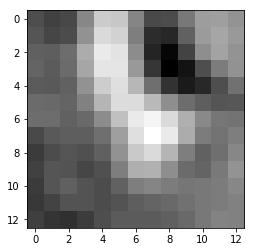

In [198]:
gen = train_generator(all_files, batch_size=batch_size, patch_size=patch_size)
a = next(gen)
a = normalize(a)
plt.imshow(a[0, 0, 6, :].astype(np.float32), cmap='gray')

In [134]:
def show_generator_output(sess, input_z):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param input_z: Input Z Tensor
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

    samples = sess.run(
        generator(input_z, reuse=True, training=False),
        feed_dict={input_z: example_z})

    plt.figure()
    plt.imshow(samples[0, 0, 6, :, :], cmap='gray')
    plt.show()

def normalize(x):
    means = np.mean(x, axis=(2, 3, 4))
    means.shape=(batch_size, 3, 1, 1, 1)

    sds = np.std(x.astype(np.float32), axis=(2, 3, 4))
    sds.shape = (batch_size, 3, 1, 1, 1)
    return (x - means) / sds

## Semi-supervised learning

In [189]:
def train_generator(train_images, batch_size, patch_size):
    """
    Generates patches of size `patch_size` around lesion voxels. It procedes by first randomly sampling one of
    the 20 MRI scans. Then it takes a patch of size `patch_size x patch_size x patch_size` centered around 
    this voxel.
    
    :param batch_size: number of patches sampled
    :param patch_size: size of sampled patch
    """
    while True:

        # Loop over batches
        samples = []
        for i in range(batch_size):
            # Sample an image
            sampled_image = np.random.randint(len(train_images))
            x, y = train_images[sampled_image]
            x, y = x[:, 0:-1:2, 0:-1:2, 0:-1:2], y[0:-1:2, 0:-1:2, 0:-1:2]

            # Sample a lesion voxel
            lesion_voxels = np.where(y == 1)
            #non_lesion_voxels = np.where(y != 0)
            #if np.random.choice(2) == 0:
            sampled_voxel_index = np.random.randint(len(lesion_voxels[0]))
            sampled_voxel = list(lesion_voxels[i][sampled_voxel_index] for i in range(3))
            #else:
            #    sampled_voxel_index = np.random.randint(len(non_lesion_voxels[0]))
            #    sampled_voxel = list(non_lesion_voxels[i][sampled_voxel_index] for i in range(3))

            # Calculate sampled patch
            sampled_patch = x[:,
                              int(sampled_voxel[0] - patch_size / 2 + 1) : int(sampled_voxel[0] + patch_size / 2), 
                              int(sampled_voxel[1] - patch_size / 2 + 1) : int(sampled_voxel[1] + patch_size / 2),
                              int(sampled_voxel[2] - patch_size / 2 + 1) : int(sampled_voxel[2] + patch_size / 2)]

            samples.append(sampled_patch)

        results = np.stack(samples)
        yield results

In [190]:
foo = train_generator(all_files, 10, 10)

In [191]:
next(foo)

array([[[[[  2.05039978e-05,   2.10404396e-05,   2.21133232e-05, ...,
             2.65240669e-05,   2.22921371e-05,   2.12788582e-05],
          [  2.11000443e-05,   2.13980675e-05,   2.22325325e-05, ...,
             2.61664391e-05,   2.45571136e-05,   2.21729279e-05],
          [  2.12192535e-05,   2.19345093e-05,   2.16364861e-05, ...,
             2.52127647e-05,   2.47359276e-05,   2.26497650e-05],
          ..., 
          [  2.12788582e-05,   2.25305557e-05,   2.37226486e-05, ...,
             2.20537186e-05,   2.07424164e-05,   2.12192535e-05],
          [  2.08020210e-05,   2.15768814e-05,   2.26497650e-05, ...,
             2.06232071e-05,   2.06232071e-05,   1.99079514e-05],
          [  2.14576721e-05,   2.18749046e-05,   2.19345093e-05, ...,
             1.96099281e-05,   1.98483467e-05,   1.77621841e-05]],

         [[  2.05039978e-05,   2.15768814e-05,   2.19941139e-05, ...,
             2.46763229e-05,   2.22921371e-05,   2.09808350e-05],
          [  2.12192535e-05,  

# Conclusion

# References